In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.initializers import *
from keras.models import load_model
from keras.losses import *
import scipy.io.wavfile as sciwav
import multiprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from nn_experimental import *
from perceptual_loss import *
from evaluation import *

In [4]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [5]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


In [6]:
input_dim = (WINDOW_SIZE, 1)

In [7]:
# softmax hardness variable
tau = K.variable(0.0001, name = "hardness")

In [8]:
DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR
    
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 48
    FILT_SIZE = 9
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    enc = channel_change_block(NCHAN, FILT_SIZE)(enc)
    enc = downsample_block(NCHAN, FILT_SIZE)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 2)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 4)(enc)
    enc = channel_change_block(1, FILT_SIZE)(enc)
    
    # quantization
    enc = Reshape((CHANNEL_SIZE,))(enc)
    enc = DeltaQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE, NBINS))
    dec = dec_input
    
    # dequantization
    dec = DeltaDequantization()(dec)    
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    dec = channel_change_block(NCHAN, FILT_SIZE)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 4)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 2)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1)(dec)
    dec = upsample_block(NCHAN, FILT_SIZE)(dec)
    dec = channel_change_block(1, FILT_SIZE)(dec)

    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [9]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    loss = tau * entropy
    return K.switch(QUANTIZATION_ON, loss, K.zeros_like(loss))

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return sparsity
    #return K.switch(QUANTIZATION_ON, sparsity, K.zeros_like(sparsity))

In [10]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'ChannelResize1D' : ChannelResize1D,
                  'LinearUpSampling1D' : LinearUpSampling1D,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'DeltaQuantization' : DeltaQuantization,
                  'DeltaDequantization' : DeltaDequantization,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'DFT_REAL' : DFT_REAL,
                  'DFT_IMAG' : DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'keras_dft_mag' : keras_dft_mag,
                  'keras_dct' : keras_dct,
                  'perceptual_transform' : perceptual_transform,
                  'perceptual_distance' : perceptual_distance}

In [11]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

In [12]:
# model parameters
loss_weights = [30.0, 1.0, 5.0, 1.0]
loss_functions = [rmse, perceptual_distance, code_sparsity, code_entropy]
n_recons = 2
n_code = 2
assert(n_recons + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [13]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_reconstructed = decoder(model_embedding)

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2_1/add_12/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2_1/add_12/add:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_1_1/delta_quantization_1/Reshape_49:0' shape=(?, 256, 32) dtype=float32>, <tf.Tensor 'model_1_1/delta_quantization_1/Reshape_49:0' shape=(?, 256, 32) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [14]:
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 256, 32)           188494.0  
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            271597    
Total params: 460,091
Trainable params: 460,091
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         30787.1
Avg err:     115.371
PESQ:        1.29870545864


[30787.137, 115.37067, 1.2987054586410522]

In [16]:
# saves current model
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    #os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    #np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('./' + prefix + '_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [17]:
def evaluate_training(autoencoder, lead = ""):
    def set_evaluation(windows, wparams, eval_idxs):
        before_after_pairs = np.array([run_model_on_windows(windows[i],
                                                    wparams[i],
                                                    autoencoder,
                                                    argmax = True)
                                       for i in eval_idxs])
        
        NUM_THREADS = 8
        list_range = np.arange(0, len(eval_idxs))
        slices = [list_range[i:None:NUM_THREADS]
                  for i in xrange(0, NUM_THREADS)]
        
        def thread_func(pairs, q):
            for p in pairs:
                q.put(evaluation_metrics(p[0], p[1]))
                
        q = multiprocessing.Queue()
        threads = [multiprocessing.Process(target = thread_func,
                                           args = (before_after_pairs[slices[i]], q))
                   for i in xrange(0, NUM_THREADS)]
        [t.start() for t in threads]
        [t.join() for t in threads]
        
        return np.array([q.get() for i in list_range])
    
    train_eval_idxs = random.sample(range(0, len(train_windows)), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows)), VAL_EVALUATE)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    
    # train set evaluation
    train_metrics = set_evaluation(train_windows, train_wparams,
                                   train_eval_idxs)
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    
    # validation set evaluation
    val_metrics = set_evaluation(val_windows, val_wparams,
                                 val_eval_idxs)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [21]:
X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_EPOCHS = 200
EPOCHS_BEFORE_QUANT_ON = 5
EPOCHS_BEFORE_TAU = 10

ORIG_BITRATE = 256.00
TARGET_BITRATE = 16.00
PRE_ENTROPY_RATE = ORIG_BITRATE / DOWNSAMPLE_FACTOR

TARGET_ENTROPY = (TARGET_BITRATE / PRE_ENTROPY_RATE * 16.0)
TARGET_ENTROPY *= (STEP_SIZE / float(WINDOW_SIZE))
TARGET_ENTROPY_FUZZ = 0.1

TAU_CHANGE_RATE = 0.0125
MIN_TAU = 0.0125

NUM_QUANT_VECS = 5000

STARTING_LR = 0.0005
ENDING_LR = 0.0001

print "Target entropy:", TARGET_ENTROPY

 Target entropy: 1.875


In [19]:
best_val_pesq = 0.0
K.set_value(tau, 0.0)
T_i = 0.0

In [38]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})
lead = "    "

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    num_batches = len(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        # cosine annealing for model's learning rate
        train_pct = T_i / float(NUM_EPOCHS)
        opt_lr = ENDING_LR + 0.5 * (STARTING_LR - ENDING_LR) * (1 + math.cos(3.14159 * train_pct))
        T_i += (1.0 / num_batches)
        K.set_value(model.optimizer.lr, opt_lr)
        
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
               
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code       

        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau), opt_lr,
        
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 500
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy

        # ---------------------------------------------------------
        # handle updating entropy weight (tau)
        # ---------------------------------------------------------
        if (epoch >= EPOCHS_BEFORE_TAU):
            old_tau = K.get_value(tau)

            if (entropy < TARGET_ENTROPY - TARGET_ENTROPY_FUZZ):
                new_tau = old_tau - TAU_CHANGE_RATE
                if (new_tau <= MIN_TAU):
                    new_tau = MIN_TAU

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            elif (entropy > TARGET_ENTROPY + TARGET_ENTROPY_FUZZ):
                new_tau = old_tau + TAU_CHANGE_RATE

                K.set_value(tau, new_tau)
                print lead + "Updated tau from", old_tau, "to", new_tau
            else:
                print lead + "Tau stays at", old_tau
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq and entropy <= TARGET_ENTROPY):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq

            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
            patience_epoch = epoch
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (epoch == EPOCHS_BEFORE_QUANT_ON):
        print lead + "----------------"
        print lead + "Turning quantization on!"
        
        '''
        random_windows = []
        for i in xrange(0, NUM_QUANT_VECS):
            w_idx = random.randint(0, train_processed.shape[0] - 1)
            random_windows.append(train_processed[w_idx])
        
        random_windows = np.array(random_windows)
        print lead + "    Selecting random code vectors for clustering..."
        encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
        encoded_windows = encoded_windows[:, :, :1]            
        encoded_windows = np.reshape(encoded_windows, (-1, 1))
        
        print lead + "    K means clustering for bins initialization..."
        km = MiniBatchKMeans(n_clusters = NBINS).fit(encoded_windows)
        K.set_value(QUANT_BINS, km.cluster_centers_.flatten())
        '''
        K.set_value(QUANTIZATION_ON, True)
        
        #cluster_score = np.sqrt(np.median(np.min(km.transform(encoded_windows), axis = 1)))
        #print lead + "    Done. Cluster score:", cluster_score

Epoch 22:
    101120:  [1.417734 0.008075 0.645239 0.024637 0.407048] [1.417734 0.242258 0.645239 0.123187 0.407048] 0.15 0.000487840589943                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    Total time for epoch: 55.4371500015s
    ----------------
    Code entropy: 2.75243557335
    Updated tau from 0.15 to 0.162500020862
    -----------

        Train: (mean) [5146.516098 39.694689 3.559337]
        Train: (max)  [41545.218750 94.708023 4.166007]
        Train: (min)  [773.349304 16.819223 2.775689]
        Val:   (mean) [5586.271406 41.854923 3.654298]
        Val:   (max)  [33828.515625 97.064888 4.201496]
        Val:   (min)  [355.440918 10.882382 2.664336]
    Best validation mean-PESQ seen: 0.0
    Total time for evaluation: 11.3130760193s
Epoch 27:
    101120:  [1.526940 0.009089 0.673096 0.021111 0.475607] [1.526940 0.272680 0.673096 0.105557 0.475607] 0.2125 0.000481873563067                                                                                                                                                                                                                                                                                                                                                                                                                                                           

    SA1 (arg):    [4346.0283, 43.99593, 2.8657267093658447]
    SX383:        [2292.8596, 29.963701, 2.9658446311950684]
    SX383 (arg):  [2360.3555, 30.511635, 2.90883469581604]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [6303.497676 46.704558 3.308584]
        Train: (max)  [33796.476562 119.627953 3.892831]
        Train: (min)  [703.742188 17.253469 1.826797]
        Val:   (mean) [7079.042000 47.978966 3.546830]
        Val:   (max)  [36689.000000 112.112923 4.058874]
        Val:   (min)  [412.419220 12.030219 2.417457]
    Best validation mean-PESQ seen: 0.0
    Total time for evaluation: 11.578387022s
Epoch 32:
    101120:  [1.700906 0.011364 0.731477 0.019699 0.530026] [1.700906 0.340908 0.731477 0.098495 0.530026] 0.275 0.000474785227089                                                                                                                                                                                                                                      

    101120:  [1.596972 0.010980 0.662099 0.018042 0.515254] [1.596972 0.329407 0.662099 0.090212 0.515254] 0.275 0.000468336357797                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 56.3978118896s
    ----------------
    Code entropy: 1.82394503582
    Tau stays at 0.275
    ----------------
    Evaluating autoencoder...
   

        Train: (mean) [6812.365071 47.102336 3.278331]
        Train: (max)  [36243.171875 123.619820 3.924843]
        Train: (min)  [812.570496 16.729074 1.833076]
        Val:   (mean) [7479.006127 49.543493 3.419215]
        Val:   (max)  [39575.425781 113.286407 4.032109]
        Val:   (min)  [427.235229 12.239174 2.263102]
    Best validation mean-PESQ seen: 3.48670702457
    Total time for evaluation: 11.5423398018s
Epoch 41:
    101120:  [1.673687 0.011377 0.704177 0.017437 0.541012] [1.673687 0.341313 0.704177 0.087186 0.541012] 0.2875 0.000459344268899                                                                                                                                                                                                                                                                                                                                                                                                                                               

    SA1 (arg):    [4137.564, 43.746288, 2.8966102600097656]
    SX383:        [2386.8279, 30.656633, 3.0581696033477783]
    SX383 (arg):  [2438.5615, 31.031986, 3.0328385829925537]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [6839.113833 47.432475 3.288077]
        Train: (max)  [45444.175781 103.152260 3.893513]
        Train: (min)  [557.429749 15.557605 2.241193]
        Val:   (mean) [7560.326962 49.551121 3.479204]
        Val:   (max)  [37677.160156 111.996788 3.987722]
        Val:   (min)  [405.872223 11.989242 2.340971]
    Best validation mean-PESQ seen: 3.48670702457
    Total time for evaluation: 11.2920329571s
Epoch 46:
    101120:  [1.576895 0.009969 0.768171 0.016434 0.427487] [1.576895 0.299066 0.768171 0.082171 0.427487] 0.275 0.000449369771254                                                                                                                                                                                                                         

    101120:  [1.609777 0.011155 0.741766 0.016805 0.449327] [1.609777 0.334661 0.741766 0.084023 0.449327] 0.25 0.000440723970135                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 56.5084369183s
    ----------------
    Code entropy: 1.79085997388
    Tau stays at 0.25
    ----------------
    Evaluating autoencoder...
    S

        Train: (mean) [6233.007912 44.082369 3.336924]
        Train: (max)  [36449.496094 125.195900 4.029152]
        Train: (min)  [508.162506 14.919451 2.063848]
        Val:   (mean) [6782.125200 46.606721 3.549855]
        Val:   (max)  [36654.398438 104.748451 3.992282]
        Val:   (min)  [369.439941 11.376627 2.288868]
    Best validation mean-PESQ seen: 3.54763034582
    Total time for evaluation: 11.8517899513s
Epoch 55:
    101120:  [1.584117 0.010427 0.671540 0.016532 0.517118] [1.584117 0.312797 0.671540 0.082662 0.517118] 0.275 0.00042913993572                                                                                                                                                                                                                                                                                                                                                                                                                                                 

    SA1 (arg):    [4039.9048, 42.216209, 2.961653709411621]
    SX383:        [2453.3652, 30.951012, 3.014005661010742]
    SX383 (arg):  [2506.4844, 31.337034, 2.986762523651123]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [7266.149603 48.228477 3.371518]
        Train: (max)  [42701.390625 133.413177 4.036081]
        Train: (min)  [1023.258545 17.089439 2.604251]
        Val:   (mean) [7395.639038 48.510407 3.547560]
        Val:   (max)  [32949.195312 110.168564 4.114707]
        Val:   (min)  [410.883301 11.815544 2.367301]
    Best validation mean-PESQ seen: 3.54763034582
    Total time for evaluation: 11.2340989113s
Epoch 60:
    101120:  [1.607182 0.010285 0.709495 0.016288 0.507704] [1.607182 0.308543 0.709495 0.081440 0.507704] 0.275 0.000416759712003                                                                                                                                                                                                                          

    101120:  [1.439684 0.008577 0.674908 0.015650 0.429215] [1.439684 0.257311 0.674908 0.078250 0.429215] 0.25 0.00040633341613                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    Total time for epoch: 56.8242740631s
    ----------------
    Code entropy: 1.85596657504
    Tau stays at 0.25
    ----------------
    Evaluating autoencoder...
    S

        Val:   (mean) [7042.837826 47.343848 3.562582]
        Val:   (max)  [37031.667969 106.438622 4.037814]
        Val:   (min)  [386.112061 11.561255 2.043446]
    Best validation mean-PESQ seen: 3.56766865969
    Total time for evaluation: 11.0508019924s
Epoch 69:
    101120:  [1.484900 0.010577 0.655762 0.015495 0.434337] [1.484900 0.317323 0.655762 0.077477 0.434337] 0.25 0.000392715397377                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

    SA1 (arg):    [3768.6746, 40.843147, 2.9754323959350586]
    SX383:        [2128.134, 28.997826, 3.170023202896118]
    SX383 (arg):  [2169.458, 29.322607, 3.1453006267547607]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [6721.809113 46.585467 3.378831]
        Train: (max)  [31278.134766 111.151520 4.012967]
        Train: (min)  [845.621643 18.504452 2.605607]
        Val:   (mean) [6815.345987 46.565296 3.546544]
        Val:   (max)  [36208.769531 104.942741 4.105007]
        Val:   (min)  [390.106995 11.581442 2.572034]
    Best validation mean-PESQ seen: 3.56766865969
    Total time for evaluation: 11.5900318623s
Epoch 74:
    101120:  [1.481970 0.009031 0.708254 0.015214 0.426703] [1.481970 0.270942 0.708254 0.076071 0.426703] 0.25 0.000378525758334                                                                                                                                                                                                                            

    101120:  [1.602904 0.011784 0.682248 0.015838 0.487937] [1.602904 0.353531 0.682248 0.079188 0.487937] 0.25 0.000366821164793                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    Total time for epoch: 59.0062379837s
    ----------------
    Code entropy: 1.87857526579
    Tau stays at 0.25
    ----------------
    Evaluating autoencoder...
    S

        Val:   (mean) [6845.976931 46.456455 3.584668]
        Val:   (max)  [37157.890625 105.018944 4.186322]
        Val:   (min)  [370.538574 11.421547 2.305123]
    Best validation mean-PESQ seen: 3.59786972761
    Total time for evaluation: 11.5607390404s
Epoch 83:
    101120:  [1.483807 0.010185 0.609177 0.015832 0.489937] [1.483807 0.305535 0.609177 0.079158 0.489937] 0.25 0.000351825092574                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

    SA1 (arg):    [3816.4819, 41.447845, 3.0312206745147705]
    SX383:        [2196.2988, 29.218916, 2.946937084197998]
    SX383 (arg):  [2221.9783, 29.424278, 2.925689935684204]
    Format: [MSE, avg err, PESQ]
        Train: (mean) [7185.172049 48.580139 3.379689]
        Train: (max)  [40849.980469 92.599213 4.067623]
        Train: (min)  [549.167358 15.336822 2.095277]
        Val:   (mean) [7138.916683 47.537442 3.541955]
        Val:   (max)  [36399.738281 107.963234 3.955671]
        Val:   (min)  [401.029236 11.556204 2.319644]
    Best validation mean-PESQ seen: 3.6007678771
    Total time for evaluation: 11.6748330593s
Epoch 88:
    101120:  [1.542217 0.010619 0.681284 0.015935 0.462683] [1.542217 0.318572 0.681284 0.079677 0.462683] 0.25 0.000336509501965                                                                                                                                                                                                                             

    101120:  [1.388537 0.008808 0.631342 0.015276 0.416588] [1.388537 0.264226 0.631342 0.076381 0.416588] 0.25 0.000324090378833                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    Total time for epoch: 66.6277050972s
    ----------------
    Code entropy: 1.8066837769
    Tau stays at 0.25
    ----------------
    Evaluating autoencoder...
    SA1

KeyboardInterrupt: 

In [23]:
if False:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]

In [24]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [25]:
#for i in xrange(0, len(enc)):
#    print i, enc[i]

In [26]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         2805.17
Avg err:     34.3682
PESQ:        3.15644955635
MSE:         2893.21
Avg err:     35.069
PESQ:        3.11593437195
MSE:         1761.89
Avg err:     24.4067
PESQ:        3.21703958511
MSE:         1797.36
Avg err:     24.777
PESQ:        3.17567133904
MSE:         1.03937e+06
Avg err:     710.92
PESQ:        3.48286867142
MSE:         1.04656e+06
Avg err:     713.594
PESQ:        3.47047662735


[1046562.0, 713.59412, 3.4704766273498535]

In [27]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9728/10000 [============================>.] - ETA: 0s

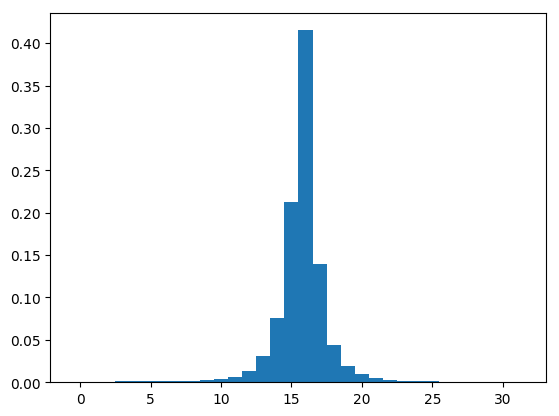

Entropy of distribution: 2.62533542827
[0.000182 0.000501 0.000777 0.000965 0.001122 0.001066 0.000924 0.000965
 0.001666 0.002972 0.004345 0.006771 0.013631 0.031060 0.076385 0.213199
 0.415132 0.139868 0.043418 0.019016 0.009647 0.005400 0.003132 0.002089
 0.001507 0.001110 0.000865 0.000690 0.000614 0.000551 0.000326 0.000105]
Bins:
[-2.374421 -1.890865 -1.605632 -1.421402 -1.286172 -1.187520 -1.116104
 -1.069820 -1.014612 -0.924972 -0.823312 -0.728913 -0.617407 -0.473658
 -0.319680 -0.153440 0.045746 0.244618 0.397691 0.533509 0.655808 0.764720
 0.864519 0.948707 1.037315 1.123776 1.217284 1.320427 1.440042 1.606232
 1.870732 2.322969]


In [28]:
probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
hist = np.sum(probs, axis = 0)
hist /= np.sum(hist)

sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
plt.show()

entropy = 0
for i in hist:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

print hist
print "Bins:"
print K.eval(QUANT_BINS)

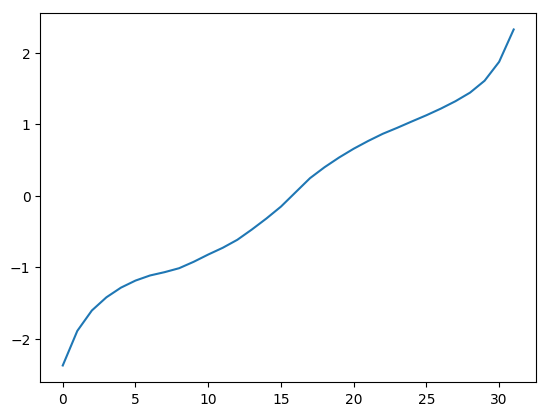

In [29]:
plt.plot(np.sort(np.array(K.eval(QUANT_BINS)).flatten()))
plt.show()

In [30]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [31]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [32]:
K.eval(enc[-1].SOFTMAX_TEMP)

507.91132

In [33]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[1.000000 1.000000 1.000000 1.000000 0.999708 1.000000 1.000000 1.000000
 1.000000 0.999942 1.000000 0.999833 1.000000 0.769917 1.000000 0.999755
 0.999973 1.000000 1.000000 1.000000 0.999715 1.000000 1.000000 1.000000
 0.976952 0.868689 1.000000 0.980621 1.000000 0.939780 0.922893 1.000000
 1.000000 1.000000 0.999606 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 0.995598 0.878736 1.000000
 0.991018 0.999968 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 0.998109 0.999120 1.000000 0.999996 1.000000 1.000000 1.000000
 1.000000 1.000000 0.999999 1.000000 0.823468 1.000000 1.000000 1.000000
 1.000000 1.000000 0.992948 1.000000 1.000000 1.000000 0.999997 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 0.999765 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 0.999999 1.000000 1.000000 1.000000
 1.000000 1.000000 0.999690 1.000000 1.000000 1.000

In [34]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.992984
0.958635602679


Original


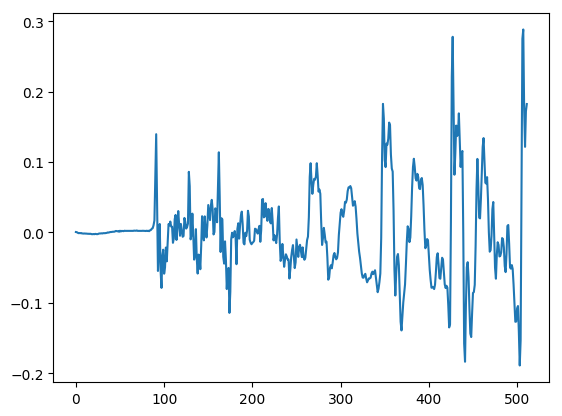

Reconstruction


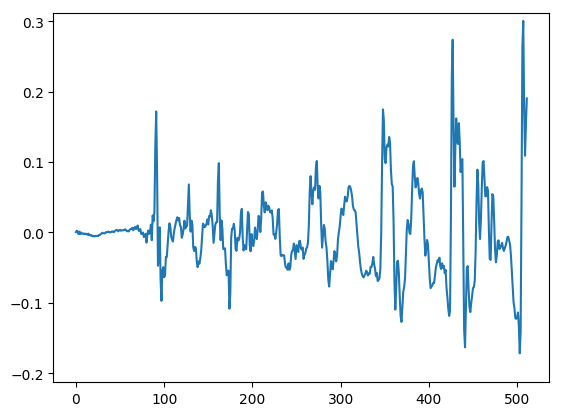

Code (argmax)


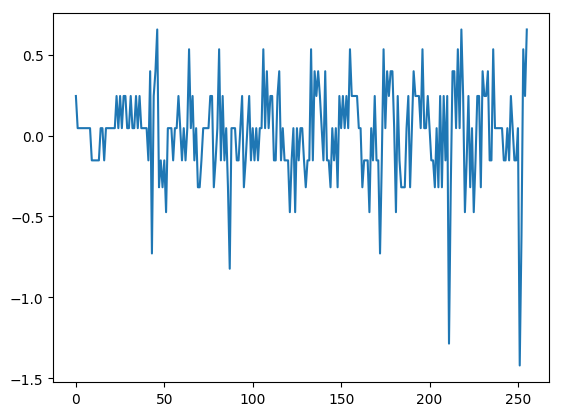

Code (non-argmax)


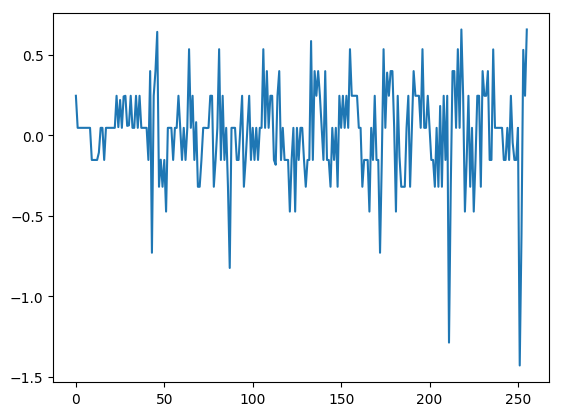

Difference


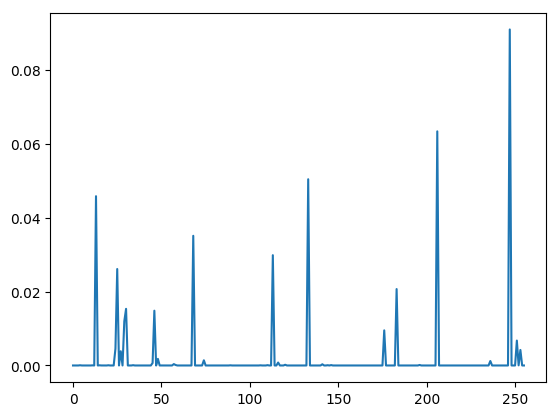

Error


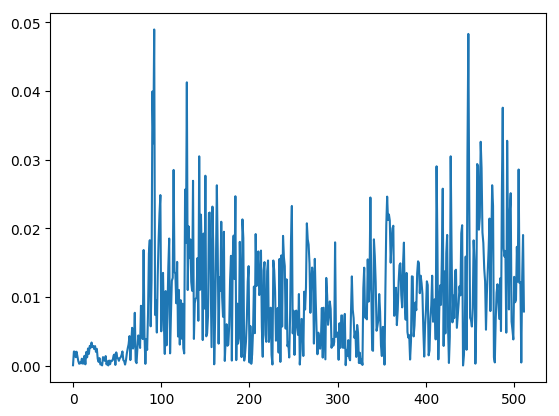

In [37]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

print "Code (argmax)"
argmax_code_vec = embed[idx]
embed_sum = np.sum(embed[idx], axis = -1)
argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
argmax_code_vec = unquantize_vec(argmax_code_vec)
plt.plot(argmax_code_vec)
plt.show()

print "Code (non-argmax)"
na_code_vec = embed[idx]
na_code_vec = unquantize_vec(na_code_vec)
plt.plot(na_code_vec)
plt.show()

print "Difference"
plt.plot(abs(argmax_code_vec - na_code_vec))
plt.show()
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()